<a href="https://colab.research.google.com/github/Akhrorfayzullo/AdminPage/blob/main/BaseModels%2BMetaLearner(raw%2BsafeMode).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install catboost torch scikit-learn pandas numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


In [ ]:
# Upload your file from your computer
from google.colab import files
import pandas as pd, os

print("➡️ Choose your dataset file (.csv or .xlsx)…")
uploaded = files.upload()  # opens a dialog

assert len(uploaded) >= 1, "No file uploaded."
fname = next(iter(uploaded))  # first uploaded file name

# Normalize path
RAW_DATA_PATH = f"/content/{fname}"
print("✅ Saved to:", RAW_DATA_PATH)

# Optional: quick peek to confirm it loaded
try:
    if fname.lower().endswith(".xlsx") or fname.lower().endswith(".xls"):
        df_preview = pd.read_excel(RAW_DATA_PATH)
    else:
        # fallback to latin-1 if utf-8 fails
        try:
            df_preview = pd.read_csv(RAW_DATA_PATH)
        except UnicodeDecodeError:
            df_preview = pd.read_csv(RAW_DATA_PATH, encoding="latin-1")
    print(f"Preview: shape={df_preview.shape}")
    display(df_preview.head(3))
except Exception as e:
    print("⚠️ Could not preview file:", e)


➡️ Choose your dataset file (.csv or .xlsx)…


Saving Final_Dataset_updated_file_without_Tb.csv to Final_Dataset_updated_file_without_Tb.csv
✅ Saved to: /content/Final_Dataset_updated_file_without_Tb.csv
Preview: shape=(942, 27)


,Reference,TEST #,Position,ls,db,Rr,b,h,d,cso,...,Nl,Ab,At,fc,fy,fyt,fsc,fsu,Mu,MyResult
0,"Chinn, Ferguson, and Thompson 1955 + ...",D31,1.0,5.5,0.375,0.0727,3.69,NaN,6.5,1.47,...,0.0,0.11,0,4700.0,79,0.0,60.70,60.35,40,6704.109635
1,...,D36,1.0,5.5,0.375,0.0727,3.69,NaN,6.5,1.47,...,0.0,0.11,0,4410.0,79,0.0,49.21,48.95,32,5435.078009
2,...,D10,1.0,7.0,0.750,0.0727,3.62,NaN,6.5,1.06,...,0.0,0.44,0,4370.0,57,0.0,26.41,26.27,65,11667.580591


In [ ]:
# ====== CONFIG ======
TARGET          = "MyResult"             # Total Bond Strength
ID_COLS         = ["Reference", "TEST #"]
CAT_COLS        = ["Position"]           # categorical column(s) if present
RANDOM_STATE    = 42
ALPHA_SAFETY    = 0.05                   # 5% allowed over-pred rate (try 0.01 for stricter)

# ====== HELPERS ======
import numpy as np, pandas as pd
from sklearn.metrics import r2_score

def rmse_np(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    return float(np.sqrt(np.mean((y_pred-y_true)**2)))

def mae_np(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    return float(np.mean(np.abs(y_pred-y_true)))

def overrate(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    return float(np.mean(y_pred > y_true))  # fraction of over-predictions

def report_metrics(y_true, y_pred, tag="model"):
    print(f"{tag:<28} R²={r2_score(y_true,y_pred):.4f} | RMSE={rmse_np(y_true,y_pred):,.2f} | "
          f"MAE={mae_np(y_true,y_pred):,.2f} | Overrate={overrate(y_true,y_pred):.3f}")

def clean_dataframe(path, target=TARGET, id_cols=ID_COLS, cat_cols=CAT_COLS):
    df = pd.read_csv(path) if path.lower().endswith(".csv") else pd.read_excel(path)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    JUNK = {"", "*", " * ", " *", "* ", "—", "–", "-", "NA", "N/A", "na", "nan", "NaN"}
    def clean_token(x):
        if pd.isna(x): return np.nan
        if isinstance(x, str) and x.strip() in JUNK: return np.nan
        return x
    df = df.applymap(clean_token)
    feats = [c for c in df.columns if c not in id_cols+[target]]
    num_cand = [c for c in feats if c not in cat_cols]
    for c in num_cand:  # coerce numerics
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df[target] = pd.to_numeric(df[target], errors="coerce")
    df = df.dropna(subset=[target]).reset_index(drop=True)
    return df

def conformal_lower_quantile(residuals, alpha=ALPHA_SAFETY):
    # residuals = yhat - y (positive means over-prediction)
    return float(np.quantile(residuals, 1.0 - alpha, method="higher"))

def apply_lower_conformal(yhat, q):
    # conservative lower estimate
    return yhat - q

In [ ]:
df = clean_dataframe(RAW_DATA_PATH)

from sklearn.model_selection import train_test_split
feature_cols = [c for c in df.columns if c not in ID_COLS + [TARGET]]
X_full = df[feature_cols].copy()
y_full = df[TARGET].values

# Final hold-out TEST set (never touched by calibration)
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

num_cols = [c for c in feature_cols if c not in CAT_COLS]
cat_cols = [c for c in CAT_COLS if c in df.columns]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")),
                     ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

PREP = ColumnTransformer([("num", num_pipe, num_cols),
                          ("cat", cat_pipe, cat_cols)], remainder="drop")


/tmp/ipython-input-3325171841.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-3325171841.py:36: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_token)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

base_defs = {
    "ann":  MLPRegressor(hidden_layer_sizes=(64,64), activation="relu", max_iter=1000, random_state=RANDOM_STATE),
    "rf":   RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    "svr":  SVR(C=5.0, epsilon=0.1),
    "gbr":  GradientBoostingRegressor(random_state=RANDOM_STATE),
    "knn":  KNeighborsRegressor(n_neighbors=7),
}
base_pipes = {name: make_pipeline(PREP, est) for name, est in base_defs.items()}

# OOF predictions on TRAIN only
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof = {name: np.zeros(len(X_train)) for name in base_pipes}

for tr_idx, va_idx in kf.split(X_train):
    Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    ytr      = y_train[tr_idx]
    for name, pipe in base_pipes.items():
        pipe.fit(Xtr, ytr)
        oof[name][va_idx] = pipe.predict(Xva)

# Conformal q per base (calibration = OOF residuals)
q_base = {}
for name, preds in oof.items():
    q_base[name] = conformal_lower_quantile(preds - y_train, ALPHA_SAFETY)

# Refit on all TRAIN and predict on TEST (raw + SAFE)
pred_test_raw, pred_test_safe = {}, {}
for name, pipe in base_pipes.items():
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    pred_test_raw[name]  = yhat
    pred_test_safe[name] = apply_lower_conformal(yhat, q_base[name])

print("== Base models (TEST) ==")
for name in base_defs:
    report_metrics(y_test, pred_test_raw[name],  f"{name.upper():<10} raw")
    report_metrics(y_test, pred_test_safe[name], f"{name.upper():<10} SAFE")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perce

== Base models (TEST) ==
ANN        raw               R²=0.9734 | RMSE=8,138.29 | MAE=5,707.21 | Overrate=0.471
ANN        SAFE              R²=0.8692 | RMSE=18,064.01 | MAE=16,475.43 | Overrate=0.021
RF         raw               R²=0.9731 | RMSE=8,197.59 | MAE=2,619.75 | Overrate=0.519
RF         SAFE              R²=0.9635 | RMSE=9,546.10 | MAE=5,917.75 | Overrate=0.053
SVR        raw               R²=-0.0622 | RMSE=51,472.46 | MAE=33,631.24 | Overrate=0.476
SVR        SAFE              R²=-1.0692 | RMSE=71,839.72 | MAE=52,220.43 | Overrate=0.074
GBR        raw               R²=0.9758 | RMSE=7,761.72 | MAE=3,547.42 | Overrate=0.497
GBR        SAFE              R²=0.9632 | RMSE=9,585.44 | MAE=6,934.32 | Overrate=0.069
KNN        raw               R²=0.9232 | RMSE=13,837.24 | MAE=7,610.69 | Overrate=0.460
KNN        SAFE              R²=0.8135 | RMSE=21,568.89 | MAE=17,010.45 | Overrate=0.042


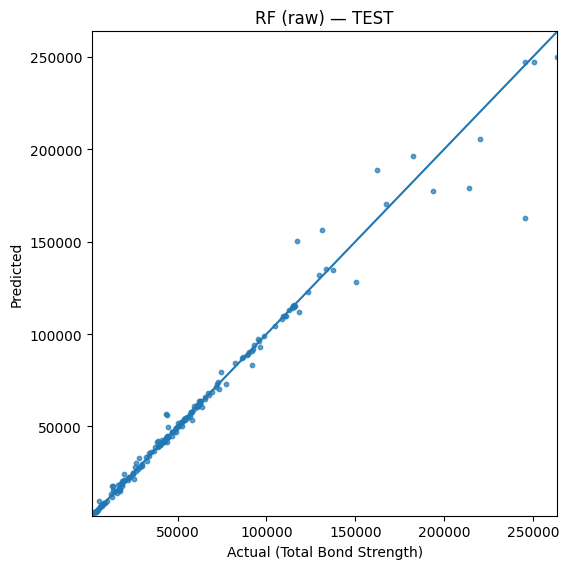

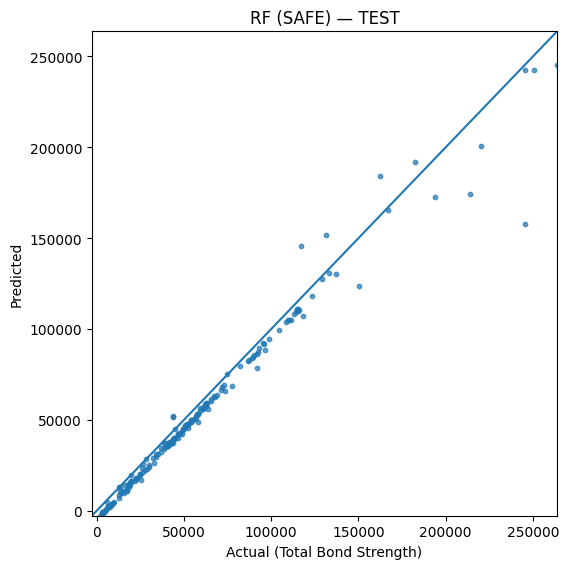

In [ ]:
import matplotlib.pyplot as plt

def scatter(y, yhat, title, fname):
    plt.figure(figsize=(5.8,5.8))
    plt.scatter(y, yhat, s=10, alpha=0.7)
    lo, hi = min(y.min(), yhat.min()), max(y.max(), yhat.max())
    plt.plot([lo,hi],[lo,hi])
    plt.xlim(lo,hi); plt.ylim(lo,hi)
    plt.xlabel("Actual (Total Bond Strength)"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

scatter(y_test, pred_test_raw["rf"],  "RF (raw) — TEST",  "/content/rf_raw_scatter.png")
scatter(y_test, pred_test_safe["rf"], "RF (SAFE) — TEST", "/content/rf_safe_scatter.png")


In [ ]:
# ===== Safety config =====
ALPHA_SAFETY = 0.01          # stricter than 0.05; try 0.005 or 0.001 if needed
SAFETY_MODE  = "per_bin"     # "quantile" | "per_bin" | "zero_over"
N_BINS       = 6             # only used for per_bin
MARGIN       = 0.00          # add small buffer ≥0 (e.g., 0.05 to inflate caps by 5%)

import numpy as np

def finite_sample_q(residuals, alpha=ALPHA_SAFETY):
    """One-sided conformal finite-sample quantile:
       rank = ceil((m+1)*(1-alpha)), then pick that order statistic."""
    r = np.asarray(residuals).ravel()
    m = len(r)
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank,1), m)
    r_sorted = np.sort(r)
    return float(r_sorted[rank-1])

def q_quantile(residuals):
    q = finite_sample_q(residuals, ALPHA_SAFETY)
    return q*(1.0+MARGIN)

def q_zero_over(residuals):
    # Hard-safe: no over on calibration (max residual), optionally add margin
    return float(np.max(residuals))*(1.0+MARGIN)

def fit_per_bin_q(scale_cal, residuals_cal, mode="quantile", n_bins=N_BINS):
    """Compute q per scale bin (scale = e.g., predicted yhat_cal or physics φ)."""
    s = np.asarray(scale_cal).ravel()
    r = np.asarray(residuals_cal).ravel()
    edges = np.quantile(s, np.linspace(0,1,n_bins+1))
    qs = []
    for i in range(n_bins):
        left, right = edges[i], edges[i+1]
        if i < n_bins-1:
            mask = (s >= left) & (s < right)
        else:
            mask = (s >= left) & (s <= right)
        r_bin = r[mask]
        if len(r_bin)==0:
            qs.append(0.0)
        else:
            qs.append(q_zero_over(r_bin) if mode=="zero_over" else q_quantile(r_bin))
    return edges, np.array(qs)

def apply_per_bin_q(yhat, edges, qs):
    idx = np.minimum(np.searchsorted(edges[1:], yhat, side='right'), len(qs)-1)
    return yhat - qs[idx]


In [ ]:
# OOF residuals (calibration on TRAIN)
# oof[name] already exists from your CV loop; it's the OOF yhat for TRAIN rows
q_base = {}
perbin_base = {}  # store (edges, qs) if per_bin mode is used

# We'll use a "scale" to bin by. Prefer a physics scale φ = sqrt(fc)*pi*ls if available; else use OOF yhat.
have_fc_ls = all(c in df.columns for c in ["fc","ls"])
if have_fc_ls:
    phi_train = (np.sqrt(np.clip(df.loc[X_train.index, "fc"].values, 1e-6, None))
                 * np.pi * df.loc[X_train.index, "ls"].values)
else:
    phi_train = None  # we'll fall back to yhat for binning

for name, preds in oof.items():
    resid = preds - y_train  # positive = over-prediction on TRAIN folds
    if SAFETY_MODE == "per_bin":
        scale_cal = phi_train if phi_train is not None else preds  # OOF yhat
        edges, qs = fit_per_bin_q(scale_cal, resid, mode="zero_over" if SAFETY_MODE=="zero_over" else "quantile")
        perbin_base[name] = (edges, qs)
        q_base[name] = None  # not used
    elif SAFETY_MODE == "zero_over":
        q_base[name] = q_zero_over(resid)
    else:  # "quantile"
        q_base[name] = q_quantile(resid)

# Refit on all TRAIN and make TEST predictions (raw + SAFE)
pred_test_raw, pred_test_safe = {}, {}
for name, pipe in base_pipes.items():
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    if SAFETY_MODE == "per_bin":
        # choose scale for TEST bins: use φ_test if available, else yhat itself
        if have_fc_ls:
            phi_test = (np.sqrt(np.clip(df.loc[X_test.index, "fc"].values, 1e-6, None))
                        * np.pi * df.loc[X_test.index, "ls"].values)
            scale_te = phi_test
        else:
            scale_te = yhat
        edges, qs = perbin_base[name]
        yhat_safe = apply_per_bin_q(scale_te, edges, qs)
    else:
        yhat_safe = yhat - q_base[name]
    pred_test_raw[name]  = yhat
    pred_test_safe[name] = yhat_safe

# Check over-prediction rates on TEST (should be ≤ alpha for quantile/per_bin; ~0 for zero_over)
print("== Base models (TEST) ==")
for name in base_defs:
    report_metrics(y_test, pred_test_raw[name],  f"{name.upper():<10} raw")
    report_metrics(y_test, pred_test_safe[name], f"{name.upper():<10} SAFE ({SAFETY_MODE})")


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


== Base models (TEST) ==
ANN        raw               R²=0.9734 | RMSE=8,138.29 | MAE=5,707.21 | Overrate=0.471
ANN        SAFE (per_bin)    R²=-3.1495 | RMSE=101,733.67 | MAE=88,179.14 | Overrate=0.000
RF         raw               R²=0.9731 | RMSE=8,197.59 | MAE=2,619.75 | Overrate=0.519
RF         SAFE (per_bin)    R²=-2.2740 | RMSE=90,366.01 | MAE=73,599.86 | Overrate=0.000
SVR        raw               R²=-0.0622 | RMSE=51,472.46 | MAE=33,631.24 | Overrate=0.476
SVR        SAFE (per_bin)    R²=-2.8902 | RMSE=98,504.06 | MAE=86,823.83 | Overrate=0.000
GBR        raw               R²=0.9758 | RMSE=7,761.72 | MAE=3,547.42 | Overrate=0.497
GBR        SAFE (per_bin)    R²=-1.9335 | RMSE=85,538.10 | MAE=68,467.07 | Overrate=0.000
KNN        raw               R²=0.9232 | RMSE=13,837.24 | MAE=7,610.69 | Overrate=0.460
KNN        SAFE (per_bin)    R²=-2.6128 | RMSE=94,926.76 | MAE=80,068.22 | Overrate=0.000


In [ ]:
# ===== Robust safety calibration (drop-in replacement) =====
ALPHA_SAFETY = 0.05      # start with 5%; use 0.01 only after things look the same
SAFETY_MODE  = "per_bin_shrunk"   # "global" | "per_bin_shrunk" | "zero_over"
N_BINS       = 4         # fewer bins = more data per bin
MIN_BIN      = 40        # fallback to global when a bin is too small
SHRINK_GAMMA = 0.5       # 0(no shrink)->bin only … 1(full shrink)->global only
CAP_P        = 0.98      # clip bin quantiles to <= global p98 of positive residuals
MARGIN       = 0.00      # optional extra safety >0

import numpy as np

def finite_sample_q(residuals, alpha=ALPHA_SAFETY):
    r = np.asarray(residuals).ravel()
    m = len(r)
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank,1), m)
    return float(np.sort(r)[rank-1])

def fit_calibrator(residuals, scale=None):
    """Return dict with calibrator parameters."""
    r = np.asarray(residuals).ravel()
    # Global target quantile (one-sided, yhat - y)
    q_global = finite_sample_q(r, ALPHA_SAFETY)

    if SAFETY_MODE == "global":
        return {"mode":"global", "q_global": q_global*(1.0+MARGIN)}

    # Per-bin with shrinkage + fallbacks
    s = np.asarray(scale).ravel() if scale is not None else None
    if s is None:
        s = np.asarray(r)  # use residuals/yhat proxy, but bins need something

    # Bin edges by quantiles of scale
    edges = np.quantile(s, np.linspace(0,1,N_BINS+1))
    qs_raw, qs = [], []

    # Clip extreme positive residuals using global pCAP to avoid outliers
    pos = r[r>0]
    cap_val = np.quantile(pos, CAP_P) if pos.size else q_global

    for i in range(N_BINS):
        left, right = edges[i], edges[i+1]
        mask = (s >= left) if i==0 else (s > left)
        if i < N_BINS-1:
            mask &= (s <= right)
        else:
            mask &= (s <= right)
        r_bin = r[mask]
        if r_bin.size < MIN_BIN:
            q_bin = q_global  # fallback
        else:
            q_bin = finite_sample_q(r_bin, ALPHA_SAFETY)
            q_bin = min(q_bin, cap_val)     # cap extreme bin
            # shrink toward global to reduce variance
            q_bin = (1.0 - SHRINK_GAMMA)*q_bin + SHRINK_GAMMA*q_global
        qs_raw.append(q_bin)
        qs.append(q_bin*(1.0+MARGIN))
    return {"mode":"per_bin_shrunk", "edges":edges, "qs":np.array(qs), "q_global": q_global*(1.0+MARGIN)}

def apply_calibrator(yhat, scale, cal):
    if cal["mode"] == "global":
        return yhat - cal["q_global"]
    # per-bin: choose bin by scale and subtract corresponding q
    edges, qs = cal["edges"], cal["qs"]
    idx = np.minimum(np.searchsorted(edges[1:], scale, side='right'), len(qs)-1)
    return yhat - qs[idx]


In [ ]:
# --- Base models and OOF predictions (TRAIN only) ---
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
import numpy as np, pandas as pd

base_defs = {
    "ann":  MLPRegressor(hidden_layer_sizes=(64,64), activation="relu",
                         max_iter=1000, random_state=RANDOM_STATE),
    "rf":   RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    "svr":  SVR(C=5.0, epsilon=0.1),
    "gbr":  GradientBoostingRegressor(random_state=RANDOM_STATE),
    "knn":  KNeighborsRegressor(n_neighbors=7),
}
base_pipes = {name: make_pipeline(PREP, est) for name, est in base_defs.items()}

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof = {name: np.zeros(len(X_train)) for name in base_pipes}

for tr_idx, va_idx in kf.split(X_train):
    Xtr, Xva = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    ytr      = y_train[tr_idx]
    for name, pipe in base_pipes.items():
        pipe.fit(Xtr, ytr)
        oof[name][va_idx] = pipe.predict(Xva)

# --- Calibrate robust per-bin-shrunk safety on TRAIN (OOF residuals) ---
have_fc_ls = all(c in df.columns for c in ["fc", "ls"])
scale_train = (np.sqrt(np.clip(df.loc[X_train.index,"fc"].values,1e-6,None))
               * np.pi * df.loc[X_train.index,"ls"].values) if have_fc_ls else None

cal_base = {}
for name, preds in oof.items():               # preds are OOF yhat on TRAIN
    resid = preds - y_train                   # positive = over-prediction
    scale = scale_train if scale_train is not None else preds
    cal_base[name] = fit_calibrator(resid, scale)

# --- Refit on all TRAIN, predict on TEST (raw + SAFE) ---
pred_test_raw, pred_test_safe = {}, {}
for name, pipe in base_pipes.items():
    pipe.fit(X_train, y_train)
    yhat = pipe.predict(X_test)
    scale_te = (np.sqrt(np.clip(df.loc[X_test.index,"fc"].values,1e-6,None))
                * np.pi * df.loc[X_test.index,"ls"].values) if have_fc_ls else yhat
    yhat_safe = apply_calibrator(yhat, scale_te, cal_base[name])
    pred_test_raw[name]  = yhat
    pred_test_safe[name] = yhat_safe

# --- Metrics on TEST ---
print("== Base models (TEST) ==")
for name in base_defs:
    report_metrics(y_test, pred_test_raw[name],  f"{name.upper():<10} raw")
    report_metrics(y_test, pred_test_safe[name], f"{name.upper():<10} SAFE ({SAFETY_MODE})")



/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perce

== Base models (TEST) ==
ANN        raw               R²=0.9734 | RMSE=8,138.29 | MAE=5,707.21 | Overrate=0.471
ANN        SAFE (per_bin_shrunk) R²=0.8565 | RMSE=18,918.16 | MAE=17,200.77 | Overrate=0.021
RF         raw               R²=0.9731 | RMSE=8,197.59 | MAE=2,619.75 | Overrate=0.519
RF         SAFE (per_bin_shrunk) R²=0.9631 | RMSE=9,599.77 | MAE=6,013.27 | Overrate=0.053
SVR        raw               R²=-0.0622 | RMSE=51,472.46 | MAE=33,631.24 | Overrate=0.476
SVR        SAFE (per_bin_shrunk) R²=-0.7615 | RMSE=66,283.76 | MAE=45,840.67 | Overrate=0.048
GBR        raw               R²=0.9758 | RMSE=7,761.72 | MAE=3,547.42 | Overrate=0.497
GBR        SAFE (per_bin_shrunk) R²=0.9613 | RMSE=9,819.44 | MAE=7,134.34 | Overrate=0.058
KNN        raw               R²=0.9232 | RMSE=13,837.24 | MAE=7,610.69 | Overrate=0.460
KNN        SAFE (per_bin_shrunk) R²=0.8150 | RMSE=21,483.62 | MAE=16,923.05 | Overrate=0.032


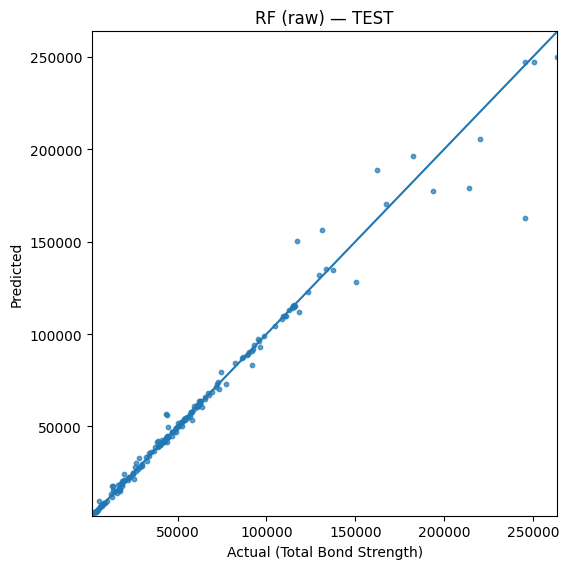

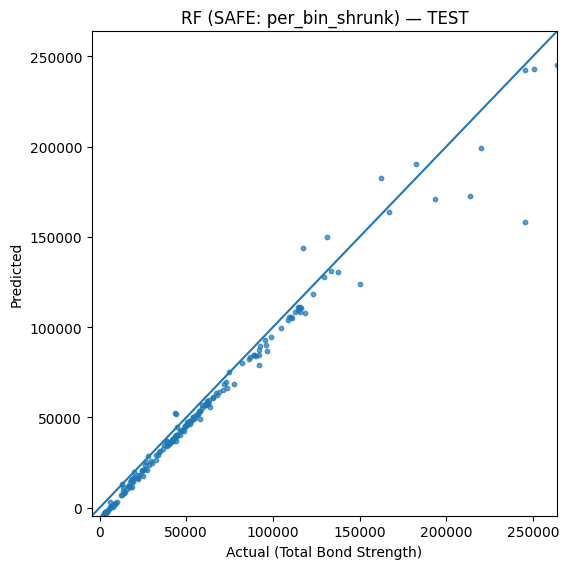

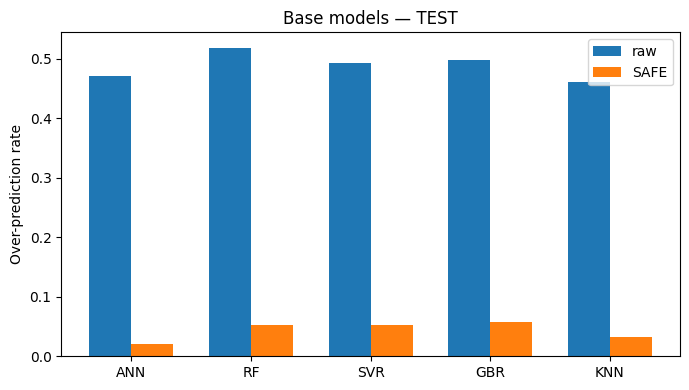

In [ ]:
import matplotlib.pyplot as plt, numpy as np

def scatter(y, yhat, title, fname):
    plt.figure(figsize=(5.8,5.8))
    plt.scatter(y, yhat, s=10, alpha=0.7)
    lo, hi = min(y.min(), yhat.min()), max(y.max(), yhat.max())
    plt.plot([lo,hi],[lo,hi])
    plt.xlim(lo,hi); plt.ylim(lo,hi)
    plt.xlabel("Actual (Total Bond Strength)"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.savefig(fname, dpi=200); plt.show()

# Example: RF raw vs SAFE
scatter(y_test, pred_test_raw["rf"],  f"RF (raw) — TEST",  "/content/rf_raw_scatter.png")
scatter(y_test, pred_test_safe["rf"], f"RF (SAFE: {SAFETY_MODE}) — TEST", "/content/rf_safe_scatter.png")

# Over-prediction rate bar chart
labels, over_raw, over_safe = [], [], []
for name in base_defs:
    labels.append(name.upper())
    over_raw.append(overrate(y_test, pred_test_raw[name]))
    over_safe.append(overrate(y_test, pred_test_safe[name]))

x = np.arange(len(labels)); w = 0.35
plt.figure(figsize=(7,4))
plt.bar(x-w/2, over_raw,  width=w, label="raw")
plt.bar(x+w/2, over_safe, width=w, label=f"SAFE")
plt.xticks(x, labels); plt.ylabel("Over-prediction rate"); plt.title("Base models — TEST")
plt.legend(); plt.tight_layout(); plt.savefig("/content/base_overrate.png", dpi=200); plt.show()


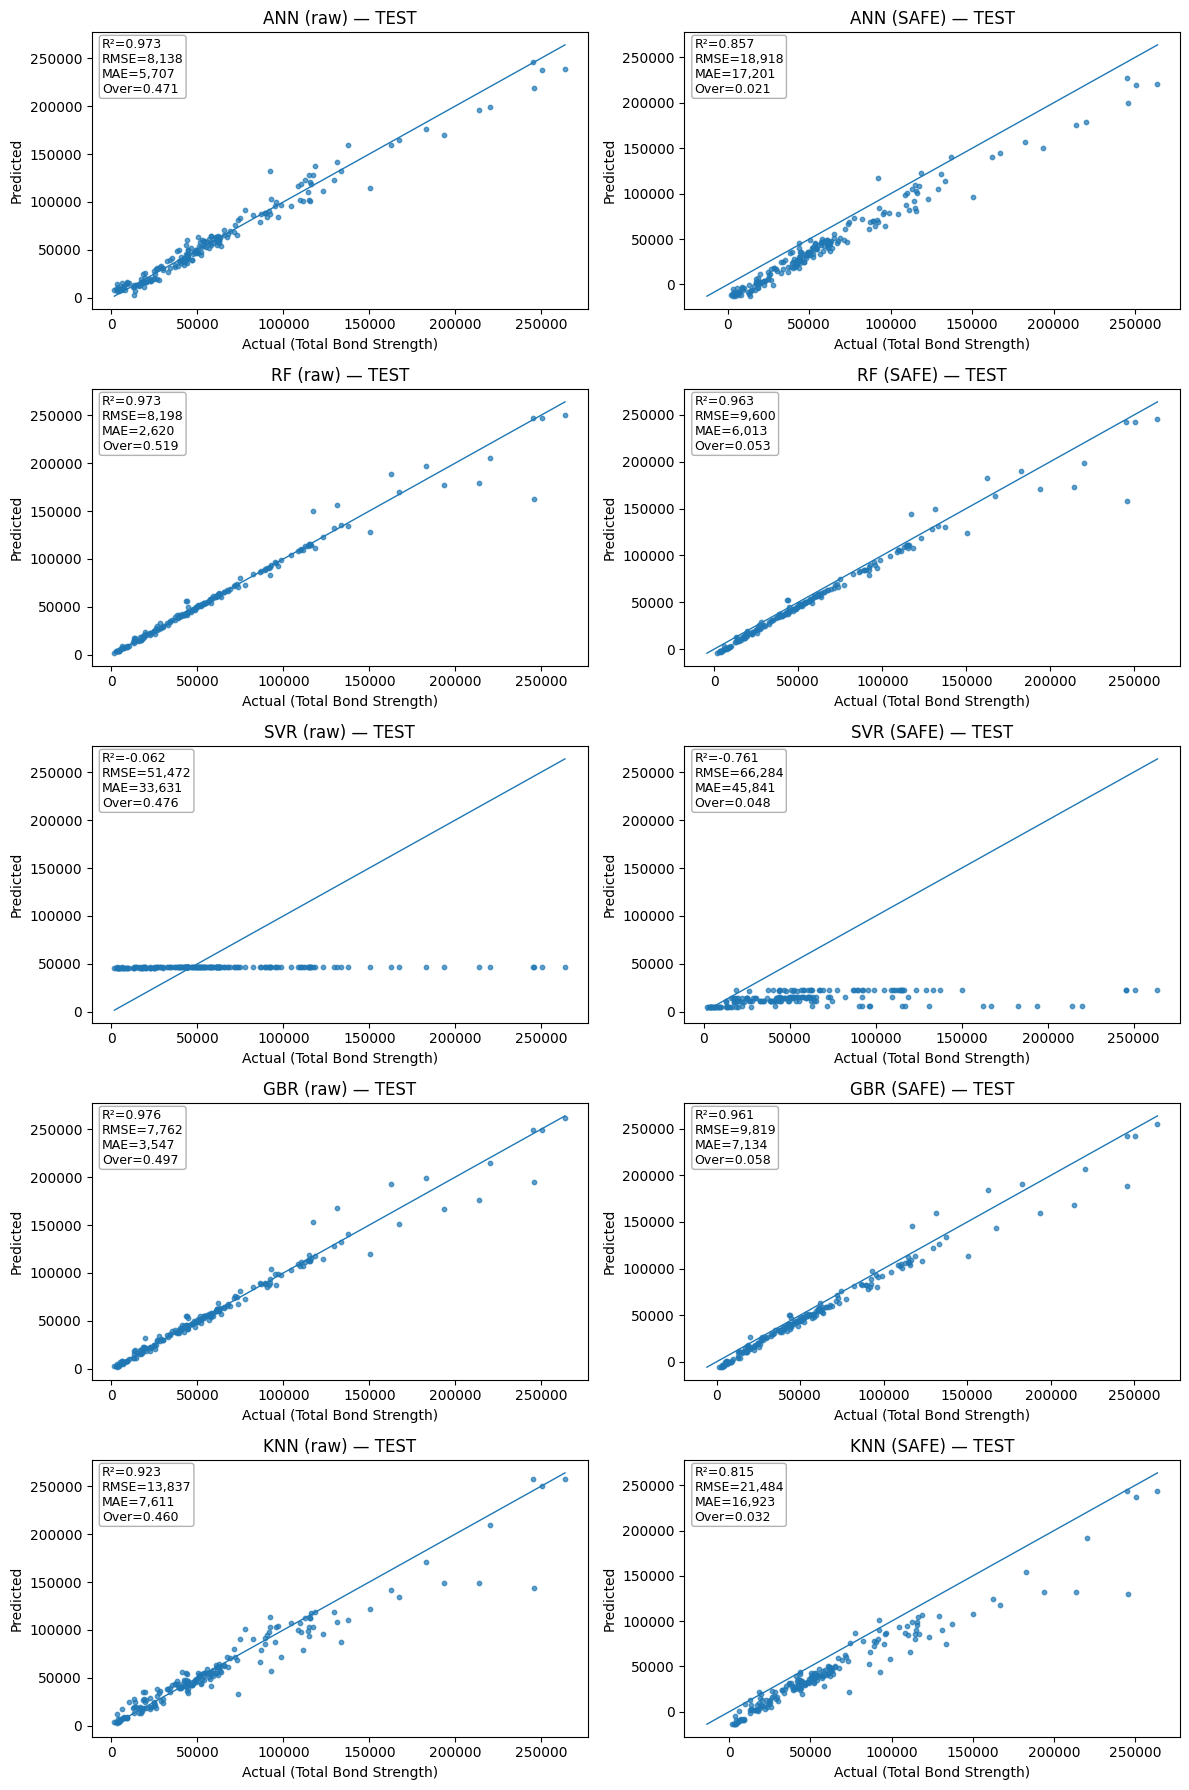

Saved /content/base_scatter_grid.png


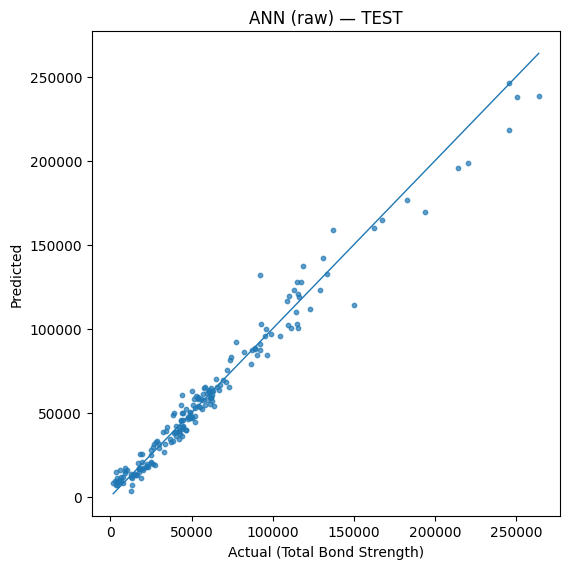

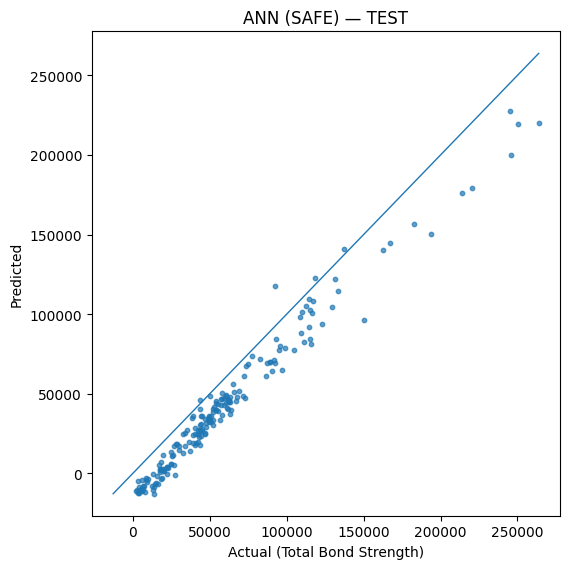

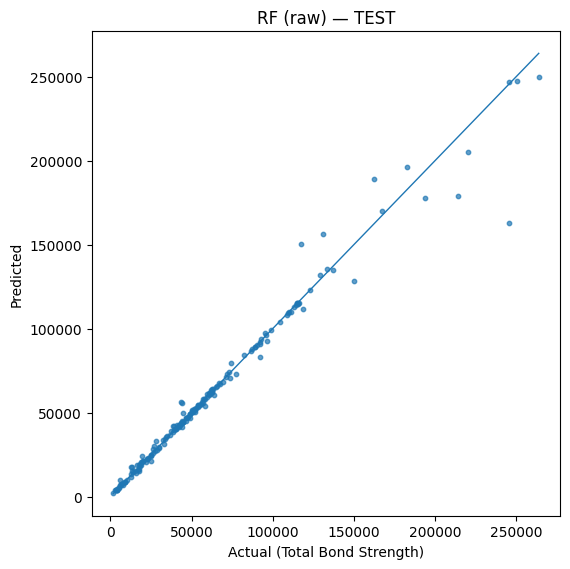

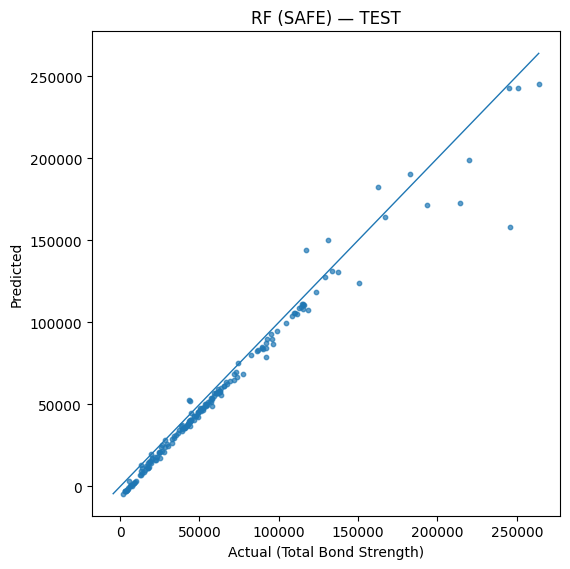

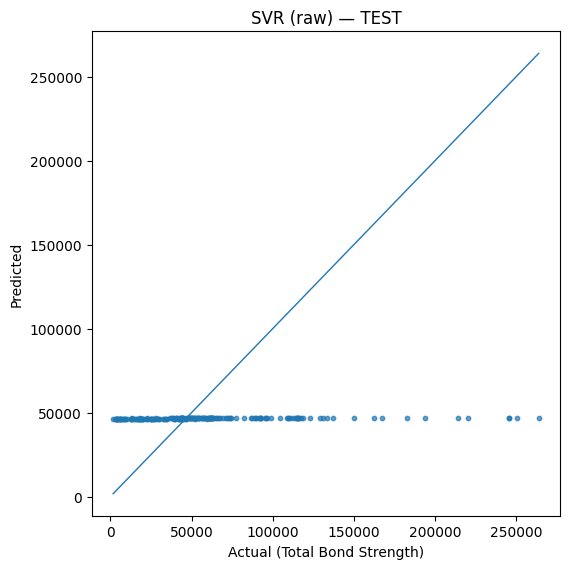

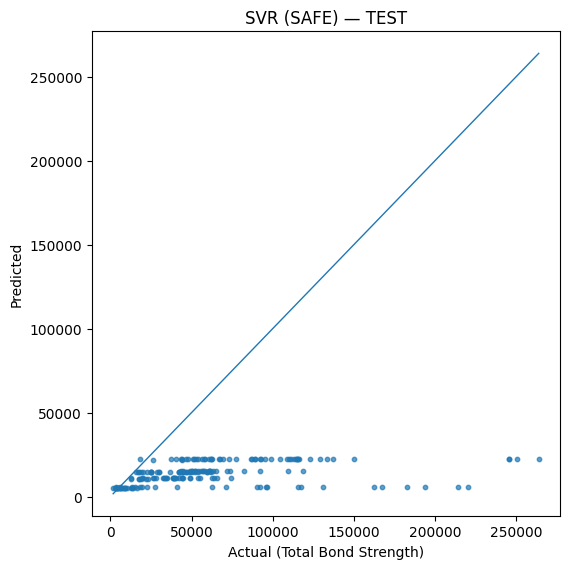

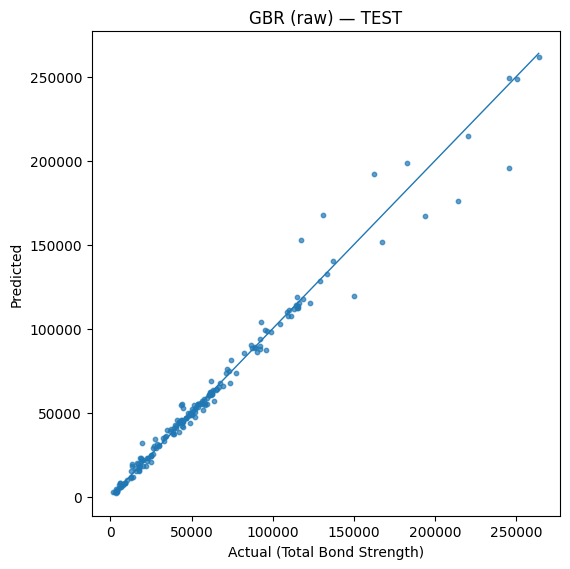

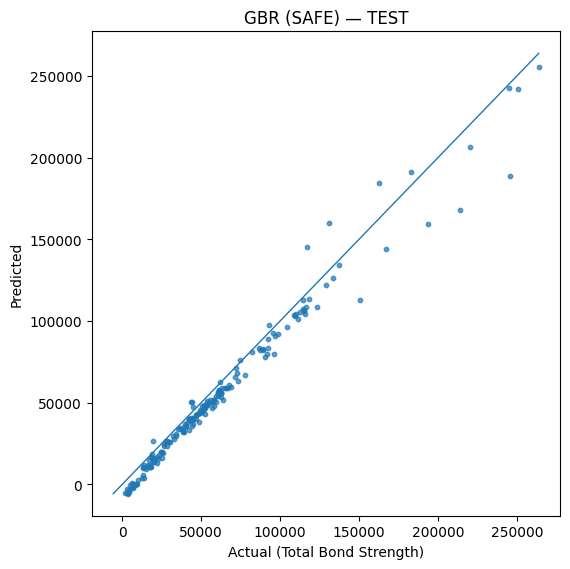

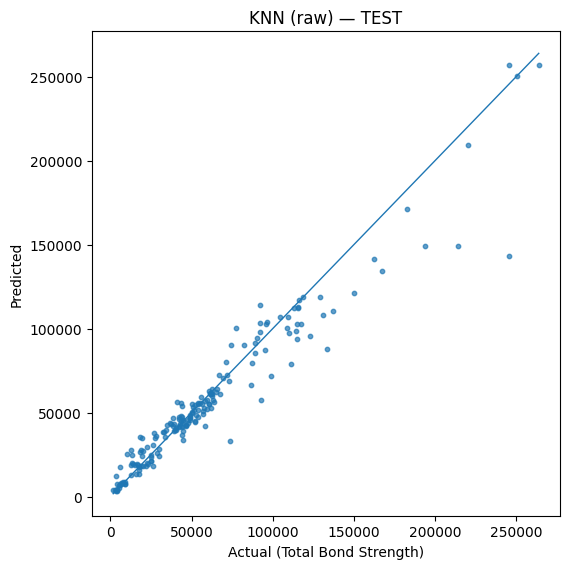

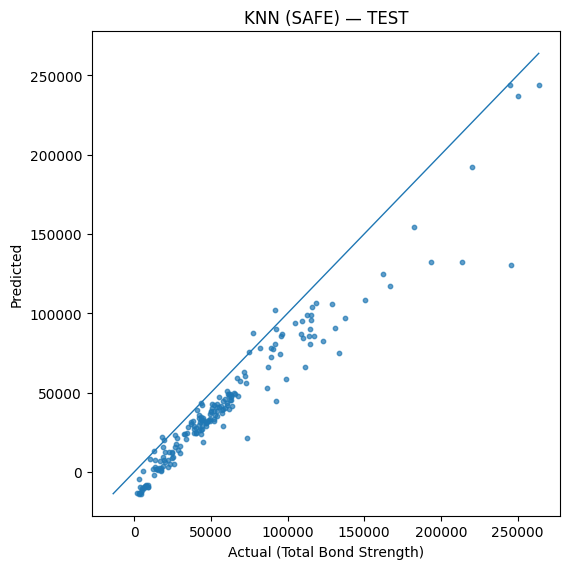

In [ ]:
# ==== Plot ALL base models: raw vs SAFE ====
import numpy as np, matplotlib.pyplot as plt

models = list(base_defs.keys())  # ["ann","rf","svr","gbr","knn"]

def _metrics_text(y, yhat):
    from sklearn.metrics import r2_score
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    mae  = float(np.mean(np.abs(yhat - y)))
    over = float(np.mean(yhat > y))
    return f"R²={r2_score(y,yhat):.3f}\nRMSE={rmse:,.0f}\nMAE={mae:,.0f}\nOver={over:.3f}"

# 1) Scatter grid (rows=models, cols=raw/SAFE)
n = len(models)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 3.6*n))
for i, name in enumerate(models):
    for j, (variant, preds) in enumerate([("raw", pred_test_raw[name]), ("SAFE", pred_test_safe[name])]):
        ax = axes[i, j] if n>1 else axes[j]
        yhat = np.asarray(preds).ravel()
        ax.scatter(y_test, yhat, s=10, alpha=0.7)
        lo = min(float(y_test.min()), float(yhat.min()))
        hi = max(float(y_test.max()), float(yhat.max()))
        ax.plot([lo, hi], [lo, hi], lw=1)
        ax.set_title(f"{name.upper()} ({variant}) — TEST")
        ax.set_xlabel("Actual (Total Bond Strength)")
        ax.set_ylabel("Predicted")
        ax.text(0.02, 0.98, _metrics_text(y_test, yhat), transform=ax.transAxes,
                va="top", ha="left", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7"))
plt.tight_layout()
plt.savefig("/content/base_scatter_grid.png", dpi=220)
plt.show()
print("Saved /content/base_scatter_grid.png")

# Also save individual scatter PNGs
for name in models:
    for variant, preds in [("raw", pred_test_raw[name]), ("SAFE", pred_test_safe[name])]:
        plt.figure(figsize=(5.8,5.8))
        yhat = np.asarray(preds).ravel()
        plt.scatter(y_test, yhat, s=10, alpha=0.7)
        lo = min(float(y_test.min()), float(yhat.min()))
        hi = max(float(y_test.max()), float(yhat.max()))
        plt.plot([lo,hi],[lo,hi], lw=1)
        plt.xlabel("Actual (Total Bond Strength)"); plt.ylabel("Predicted")
        plt.title(f"{name.upper()} ({variant}) — TEST")
        plt.tight_layout()

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best SVR params: {'transformedtargetregressor__regressor__gamma': 0.003, 'transformedtargetregressor__regressor__epsilon': 0.05, 'transformedtargetregressor__regressor__C': 100}


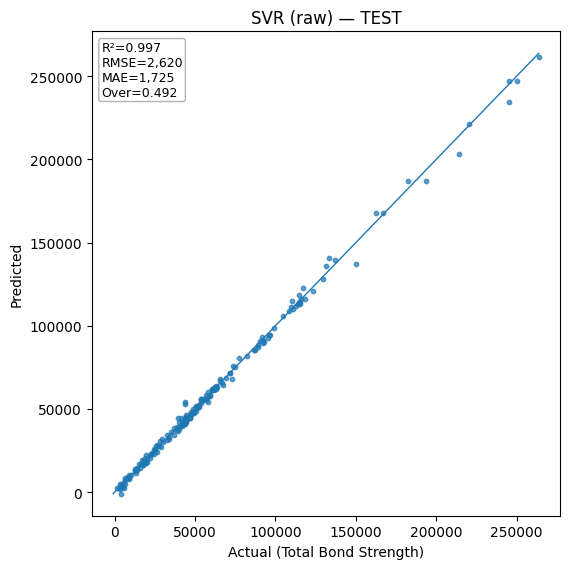

Saved /content/scatter_svr_raw.png


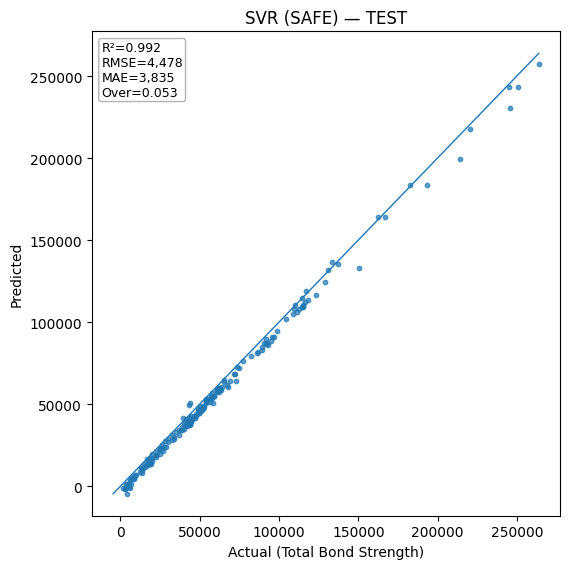

Saved /content/scatter_svr_SAFE.png


In [ ]:
# --- 1) SVR with target scaling + tuning ---
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import make_pipeline
import numpy as np

svr_ttr = TransformedTargetRegressor(
    regressor=SVR(kernel="rbf"),
    transformer=StandardScaler()      # standardize y; makes epsilon meaningful
)

pipe_svr = make_pipeline(PREP, svr_ttr)

param_distributions = {
    "transformedtargetregressor__regressor__C":      [1, 3, 10, 30, 100, 300],
    "transformedtargetregressor__regressor__gamma":  ["scale", 0.3, 0.1, 0.03, 0.01, 0.003],
    "transformedtargetregressor__regressor__epsilon":[0.05, 0.10, 0.20, 0.50, 1.0],
}

search = RandomizedSearchCV(
    pipe_svr,
    param_distributions=param_distributions,
    n_iter=35, cv=3, n_jobs=-1, random_state=RANDOM_STATE,
    scoring="neg_root_mean_squared_error", verbose=1
)
search.fit(X_train, y_train)
print("Best SVR params:", search.best_params_)
svr_best = search.best_estimator_

# --- 2) Rebuild OOF just for SVR (fixed best hyperparams) ---
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_svr = np.zeros(len(X_train))
for tr, va in kf.split(X_train):
    svr_best.fit(X_train.iloc[tr], y_train[tr])
    oof_svr[va] = svr_best.predict(X_train.iloc[va])

# Put back into your OOF dict (or create if absent)
oof["svr"] = oof_svr

# --- 3) Refit on ALL TRAIN and make TEST predictions (raw + SAFE) ---
svr_best.fit(X_train, y_train)
yhat_svr_raw  = svr_best.predict(X_test)

# Calibrate robust SAFE for SVR (uses the new per-bin-shrunk helper you added)
if all(c in df.columns for c in ["fc","ls"]):
    scale_train = (np.sqrt(np.clip(df.loc[X_train.index,"fc"].values,1e-6,None))
                   * np.pi * df.loc[X_train.index,"ls"].values)
    scale_test  = (np.sqrt(np.clip(df.loc[X_test.index,"fc"].values,1e-6,None))
                   * np.pi * df.loc[X_test.index,"ls"].values)
else:
    scale_train = oof_svr
    scale_test  = yhat_svr_raw

cal_svr = fit_calibrator(oof_svr - y_train, scale_train)
yhat_svr_safe = apply_calibrator(yhat_svr_raw, scale_test, cal_svr)

# Store back into dicts used by your plotting cells
pred_test_raw["svr"]  = yhat_svr_raw
pred_test_safe["svr"] = yhat_svr_safe

# --- 4) Plot SVR raw vs SAFE with metrics ---
import matplotlib.pyplot as plt
def _metrics_text(y, yhat):
    from sklearn.metrics import r2_score
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    mae  = float(np.mean(np.abs(yhat - y)))
    over = float(np.mean(yhat > y))
    return f"R²={r2_score(y,yhat):.3f}\nRMSE={rmse:,.0f}\nMAE={mae:,.0f}\nOver={over:.3f}"

for variant, preds in [("raw", yhat_svr_raw), ("SAFE", yhat_svr_safe)]:
    plt.figure(figsize=(5.8,5.8))
    plt.scatter(y_test, preds, s=10, alpha=0.7)
    lo = min(float(y_test.min()), float(preds.min()))
    hi = max(float(y_test.max()), float(preds.max()))
    plt.plot([lo,hi],[lo,hi], lw=1)
    plt.xlabel("Actual (Total Bond Strength)")
    plt.ylabel("Predicted")
    plt.title(f"SVR ({variant}) — TEST")
    plt.text(0.02, 0.98, _metrics_text(y_test, preds), transform=plt.gca().transAxes,
             va="top", ha="left", fontsize=9,
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.7"))
    out = f"/content/scatter_svr_{variant}.png"
    plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()
    print("Saved", out)


SVR tuned raw                R²=0.9972 | RMSE=2,619.74 | MAE=1,724.89 | Overrate=0.492
SVR tuned SAFE (per_bin_shrunk) R²=0.9920 | RMSE=4,478.40 | MAE=3,835.24 | Overrate=0.053


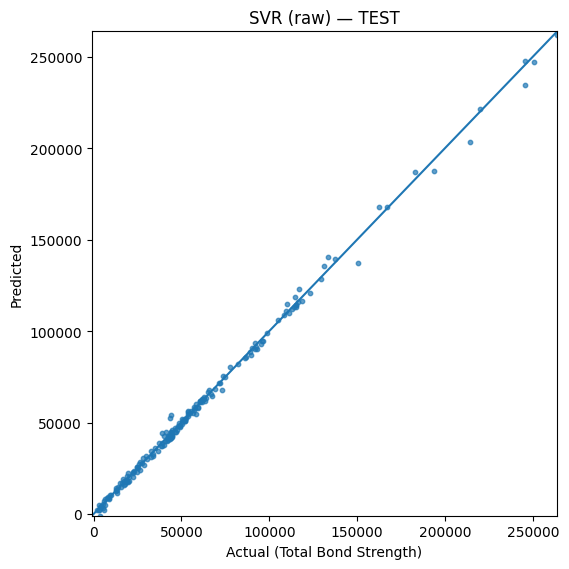

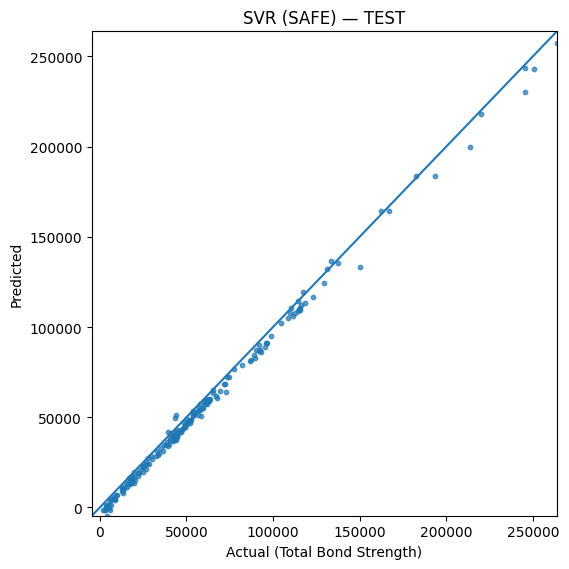

In [ ]:
# 1) register tuned SVR into your Step-1 dicts
base_pipes["svr"] = svr_best          # use the tuned pipeline
if "svr" not in base_defs: base_defs["svr"] = "tuned_svr"

# 2) rebuild OOF just for SVR
from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof["svr"] = np.zeros(len(X_train))
for tr, va in kf.split(X_train):
    svr_best.fit(X_train.iloc[tr], y_train[tr])
    oof["svr"][va] = svr_best.predict(X_train.iloc[va])

# 3) recalibrate robust SAFE for SVR from OOF residuals
have_fc_ls = all(c in df.columns for c in ["fc","ls"])
scale_train = ((np.sqrt(np.clip(df.loc[X_train.index,"fc"].values,1e-6,None))
                * np.pi * df.loc[X_train.index,"ls"].values) if have_fc_ls else oof["svr"])
cal_base["svr"] = fit_calibrator(oof["svr"] - y_train, scale_train)

# 4) refit tuned SVR on *all* TRAIN, predict on TEST (raw + SAFE)
svr_best.fit(X_train, y_train)
yhat_svr_raw = svr_best.predict(X_test)
scale_te = ((np.sqrt(np.clip(df.loc[X_test.index,"fc"].values,1e-6,None))
             * np.pi * df.loc[X_test.index,"ls"].values) if have_fc_ls else yhat_svr_raw)
yhat_svr_safe = apply_calibrator(yhat_svr_raw, scale_te, cal_base["svr"])

pred_test_raw["svr"]  = yhat_svr_raw
pred_test_safe["svr"] = yhat_svr_safe

# 5) metrics + scatter for SVR (TEST)
report_metrics(y_test, yhat_svr_raw,  "SVR tuned raw")
report_metrics(y_test, yhat_svr_safe, f"SVR tuned SAFE ({SAFETY_MODE})")

scatter(y_test, yhat_svr_raw,  "SVR (raw) — TEST",  "/content/scatter_svr_raw.png")
scatter(y_test, yhat_svr_safe, "SVR (SAFE) — TEST", "/content/scatter_svr_safe.png")


In [ ]:
# TRAIN meta-features from OOF
train_meta_raw = pd.DataFrame({f"pred_{k}": v for k, v in oof.items()}, index=X_train.index)
KEY_ORIG = [c for c in ["ls","db","fc"] if c in df.columns]
train_meta = pd.concat([train_meta_raw, df.loc[X_train.index, KEY_ORIG]], axis=1)

# TEST meta-features from refit models
test_meta_raw  = pd.DataFrame({f"pred_{k}": pred_test_raw[k] for k in oof}, index=X_test.index)
test_meta      = pd.concat([test_meta_raw, df.loc[X_test.index, KEY_ORIG]], axis=1)

y_tr_meta, y_te_meta = y_train, y_test
print("Train meta:", train_meta.shape, "| Test meta:", test_meta.shape)

# (optional) save for reuse
pd.concat([df.loc[X_train.index, ID_COLS], train_meta, pd.Series(y_tr_meta, index=train_meta.index, name=TARGET)], axis=1)\
  .to_csv("/content/step1_train_meta.csv", index=False)
pd.concat([df.loc[X_test.index, ID_COLS],  test_meta,  pd.Series(y_te_meta, index=test_meta.index,  name=TARGET)], axis=1)\
  .to_csv("/content/step1_test_meta.csv", index=False)


Train meta: (752, 8) | Test meta: (189, 8)


In [ ]:
# TRAIN meta-features from OOF
train_meta_raw = pd.DataFrame({f"pred_{k}": v for k, v in oof.items()}, index=X_train.index)
KEY_ORIG = [c for c in ["ls","db","fc"] if c in df.columns]
train_meta = pd.concat([train_meta_raw, df.loc[X_train.index, KEY_ORIG]], axis=1)

# TEST meta-features from refit models
test_meta_raw  = pd.DataFrame({f"pred_{k}": pred_test_raw[k] for k in oof}, index=X_test.index)
test_meta      = pd.concat([test_meta_raw, df.loc[X_test.index, KEY_ORIG]], axis=1)

y_tr_meta, y_te_meta = y_train, y_test
print("Train meta:", train_meta.shape, "| Test meta:", test_meta.shape)

# (optional) save for reuse
pd.concat([df.loc[X_train.index, ID_COLS], train_meta, pd.Series(y_tr_meta, index=train_meta.index, name=TARGET)], axis=1)\
  .to_csv("/content/step1_train_meta.csv", index=False)
pd.concat([df.loc[X_test.index, ID_COLS],  test_meta,  pd.Series(y_te_meta, index=test_meta.index,  name=TARGET)], axis=1)\
  .to_csv("/content/step1_test_meta.csv", index=False)


Train meta: (752, 8) | Test meta: (189, 8)



== Meta learner (TEST) ==
CatBoost meta  raw           R²=0.9868 | RMSE=5,736.09 | MAE=2,443.05 | Overrate=0.566
CatBoost meta  SAFE (per_bin_shrunk) R²=0.9839 | RMSE=6,346.47 | MAE=4,056.34 | Overrate=0.101


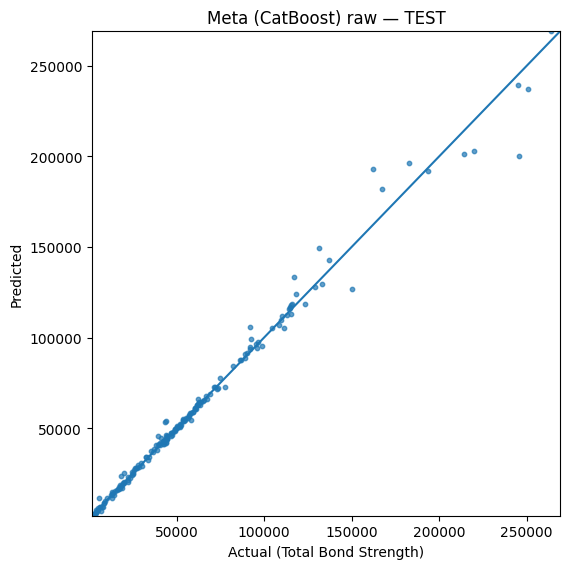

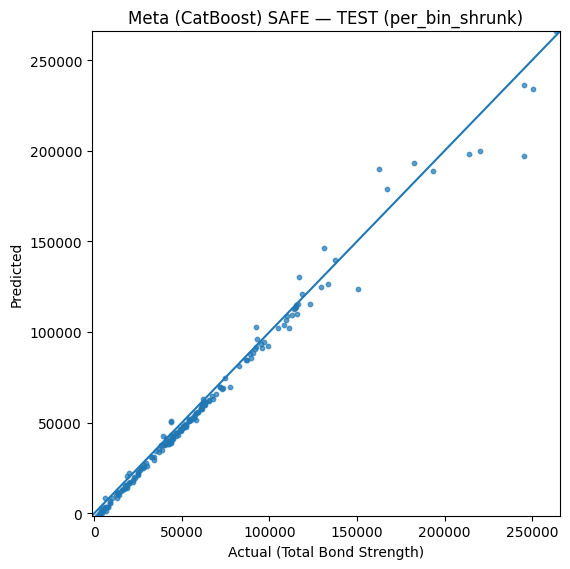

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Split TRAIN -> meta-train / meta-calibration (for clean safety calibration)
Xm_tr, Xm_cal, ym_tr, ym_cal = train_test_split(train_meta, y_tr_meta, test_size=0.2, random_state=RANDOM_STATE)

cbr = CatBoostRegressor(depth=6, learning_rate=0.05, iterations=1500,
                        loss_function="RMSE", random_seed=RANDOM_STATE, verbose=False)
cbr.fit(Xm_tr, ym_tr, eval_set=(Xm_cal, ym_cal), use_best_model=True)

# Calibrate on CAL residuals (robust per-bin-shrunk)
yhat_cal = cbr.predict(Xm_cal)
res_cal  = yhat_cal - ym_cal
if all(c in df.columns for c in ["ls","fc"]):
    scale_cal = (np.sqrt(np.clip(df.loc[Xm_cal.index,"fc"].values,1e-6,None))
                 * np.pi * df.loc[Xm_cal.index,"ls"].values)
else:
    scale_cal = yhat_cal
cal_meta = fit_calibrator(res_cal, scale_cal)

# TEST predictions (raw + SAFE)
yhat_test_raw = cbr.predict(test_meta)
scale_te_meta = ((np.sqrt(np.clip(df.loc[test_meta.index,"fc"].values,1e-6,None))
                 * np.pi * df.loc[test_meta.index,"ls"].values)
                 if all(c in df.columns for c in ["ls","fc"]) else yhat_test_raw)
yhat_test_safe = apply_calibrator(yhat_test_raw, scale_te_meta, cal_meta)

print("\n== Meta learner (TEST) ==")
report_metrics(y_te_meta, yhat_test_raw,  "CatBoost meta  raw")
report_metrics(y_te_meta, yhat_test_safe, f"CatBoost meta  SAFE ({SAFETY_MODE})")

# Plots
scatter(y_te_meta, yhat_test_raw,  "Meta (CatBoost) raw — TEST",  "/content/meta_raw_scatter.png")
scatter(y_te_meta, yhat_test_safe, f"Meta (CatBoost) SAFE — TEST ({SAFETY_MODE})", "/content/meta_safe_scatter.png")



== Meta + PINN (TEST) ==
Meta raw                     R²=0.9877 | RMSE=5,541.26 | MAE=2,393.95 | Overrate=0.577
Meta SAFE (per_bin_shrunk)   R²=0.9841 | RMSE=6,292.53 | MAE=4,220.31 | Overrate=0.095


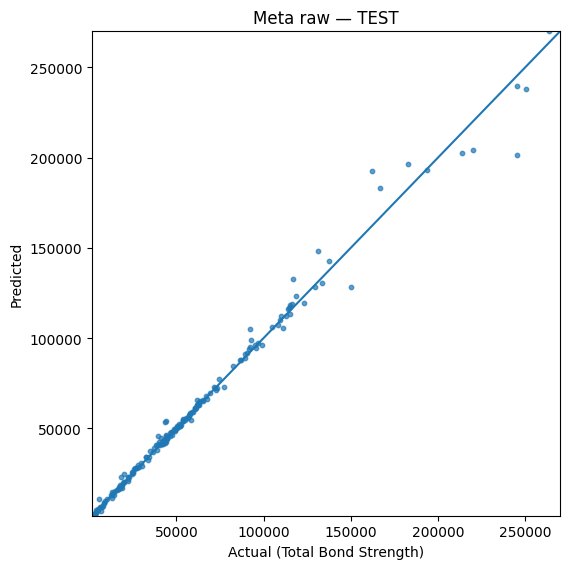

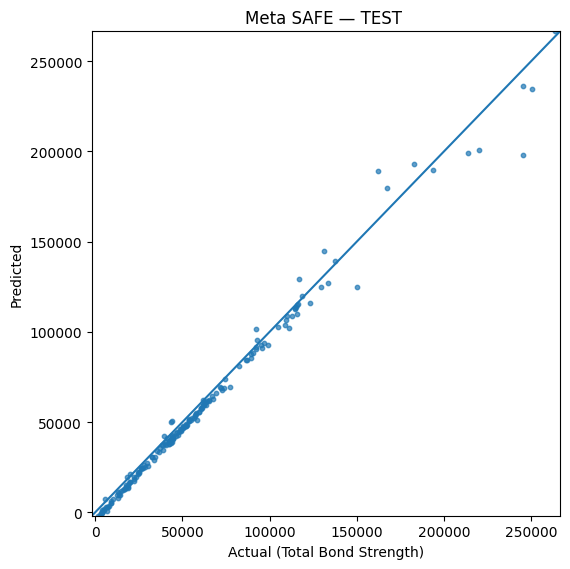

In [ ]:
import torch, torch.nn as nn, numpy as np

# Only if both 'ls' and 'fc' exist
if all(c in df.columns for c in ["ls","fc"]):
    # Physics prior: F_phys = k * sqrt(fc) * pi * ls + b  (fit on meta-train only)
    ls_tr = df.loc[Xm_tr.index, "ls"].to_numpy().reshape(-1,1)
    fc_tr = df.loc[Xm_tr.index, "fc"].to_numpy().reshape(-1,1)
    phi_tr = (np.sqrt(np.clip(fc_tr, 1e-6, None)) * np.pi * ls_tr).astype(np.float64)
    A = np.hstack([phi_tr, np.ones_like(phi_tr)])
    theta, *_ = np.linalg.lstsq(A, ym_tr.reshape(-1,1), rcond=None)
    k, b = float(theta[0,0]), float(theta[1,0])

    def F_phys(ls, fc):
        return (k*np.sqrt(np.clip(fc,1e-6,None))*np.pi*ls + b).reshape(-1,1).astype(np.float32)

    # Tensors for correction training (TRAIN only)
    Xcorr_tr = torch.tensor(Xm_tr.values, dtype=torch.float32)
    y_tr_t   = torch.tensor(ym_tr.reshape(-1,1), dtype=torch.float32)
    cbr_tr_t = torch.tensor(cbr.predict(Xm_tr).reshape(-1,1), dtype=torch.float32)
    F_tr_t   = torch.tensor(F_phys(ls_tr, fc_tr), dtype=torch.float32)

    Xcorr_cal = torch.tensor(Xm_cal.values, dtype=torch.float32)
    y_cal_t   = torch.tensor(ym_cal.reshape(-1,1), dtype=torch.float32)
    cbr_cal_t = torch.tensor(cbr.predict(Xm_cal).reshape(-1,1), dtype=torch.float32)

    class CorrectionNet(nn.Module):
        def __init__(self, in_dim):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(in_dim,32), nn.ReLU(),
                                     nn.Linear(32,16), nn.ReLU(),
                                     nn.Linear(16,1))
        def forward(self,x): return self.net(x)

    mse = nn.MSELoss()
    data_norm = torch.var(y_tr_t)+1e-12
    phys_norm = torch.var(F_tr_t)+1e-12

    def train_corr(lambda_phys=0.05, beta=1e-5, epochs=800, lr=5e-4, patience=60):
        net = CorrectionNet(Xcorr_tr.shape[1])
        opt = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-6)
        best_rmse, best_state, bad = 1e18, None, 0
        for ep in range(epochs):
            net.train()
            delta = net(Xcorr_tr); yhat = cbr_tr_t + delta
            loss = (mse(yhat, y_tr_t)/data_norm
                    + lambda_phys*mse(yhat, F_tr_t)/phys_norm
                    + beta*torch.mean(delta**2))
            opt.zero_grad(); loss.backward(); opt.step()
            # early stop on CAL
            net.eval()
            with torch.no_grad():
                rmse_val = torch.sqrt(mse(cbr_cal_t + net(Xcorr_cal), y_cal_t)).item()
            if rmse_val < best_rmse - 1e-6:
                best_rmse, best_state, bad = rmse_val, {k:v.cpu().clone() for k,v in net.state_dict().items()}, 0
            else:
                bad += 1
                if bad >= patience: break
        net.load_state_dict(best_state); return net

    net = train_corr(lambda_phys=0.05, beta=1e-5)

    # TEST predictions (raw + SAFE)
    Xcorr_te = torch.tensor(test_meta.values, dtype=torch.float32)
    with torch.no_grad():
        meta_raw_te  = cbr.predict(test_meta).reshape(-1,1)
        meta_pinn_te = (torch.tensor(meta_raw_te, dtype=torch.float32) + net(Xcorr_te)).numpy().ravel()

    # SAFE calibration on meta-CAL residuals (same robust method)
    with torch.no_grad():
        meta_pinn_cal = (cbr_cal_t + net(Xcorr_cal)).numpy().ravel()
    cal_meta_pinn = fit_calibrator(meta_pinn_cal - ym_cal, scale_cal)
    meta_pinn_te_safe = apply_calibrator(meta_pinn_te, scale_te_meta, cal_meta_pinn)

    print("\n== Meta + PINN (TEST) ==")
    report_metrics(y_te_meta, meta_pinn_te,      "Meta raw")
    report_metrics(y_te_meta, meta_pinn_te_safe, f"Meta SAFE ({SAFETY_MODE})")

    scatter(y_te_meta, meta_pinn_te,      "Meta raw — TEST",  "/content/meta_pinn_raw_scatter.png")
    scatter(y_te_meta, meta_pinn_te_safe, f"Meta SAFE — TEST ", "/content/meta_pinn_safe_scatter.png")
else:
    print("PINN step skipped: 'ls' and/or 'fc' not found.")


In [ ]:
from sklearn.metrics import r2_score

rows = [
    ["RF raw",   r2_score(y_test, pred_test_raw["rf"]),  rmse_np(y_test,pred_test_raw["rf"]),  mae_np(y_test,pred_test_raw["rf"]),  overrate(y_test,pred_test_raw["rf"])],
    ["RF SAFE",  r2_score(y_test, pred_test_safe["rf"]), rmse_np(y_test,pred_test_safe["rf"]), mae_np(y_test,pred_test_safe["rf"]), overrate(y_test,pred_test_safe["rf"])],
    ["Meta raw", r2_score(y_te_meta, yhat_test_raw),     rmse_np(y_te_meta,yhat_test_raw),     mae_np(y_te_meta,yhat_test_raw),     overrate(y_te_meta,yhat_test_raw)],
    ["Meta SAFE",r2_score(y_te_meta, yhat_test_safe),    rmse_np(y_te_meta,yhat_test_safe),    mae_np(y_te_meta,yhat_test_safe),    overrate(y_te_meta,yhat_test_safe)],
]
summary = pd.DataFrame(rows, columns=["Model","R2","RMSE","MAE","Overrate"])
summary.to_csv("/content/summary_safe_pipeline.csv", index=False)
summary


,Model,R2,RMSE,MAE,Overrate
0,RF raw,0.973057,8197.590032,2619.747501,0.518519
1,RF SAFE,0.963052,9599.765416,6013.266553,0.052910
2,Meta raw,0.986808,5736.085592,2443.051197,0.566138
3,Meta SAFE,0.983852,6346.470796,4056.341645,0.100529


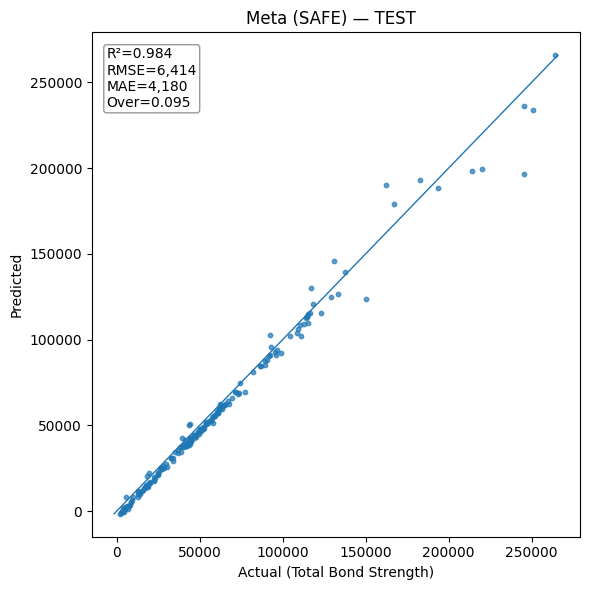

In [ ]:
# ==== Meta learner: strengthen safety and replot ====
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1) pick a stronger margin (adds % to the learned safety offset)
NEW_MARGIN = 0.05   # try 0.02 (2%), 0.05 (5%), 0.10 (10%)
MARGIN = NEW_MARGIN # <- the fit_calibrator() reads this global

# 2) re-fit the meta safety calibrator on meta-CAL (no leakage)
yhat_cal = cbr.predict(Xm_cal)
res_cal  = yhat_cal - ym_cal
if all(c in df.columns for c in ["ls","fc"]):
    scale_cal = (np.sqrt(np.clip(df.loc[Xm_cal.index,"fc"].values,1e-6,None))
                 * np.pi * df.loc[Xm_cal.index,"ls"].values)
else:
    scale_cal = yhat_cal
cal_meta = fit_calibrator(res_cal, scale_cal)   # uses updated MARGIN

# 3) get TEST predictions (raw + SAFE with the stronger margin)
yhat_test_raw  = cbr.predict(test_meta)
scale_te_meta  = ((np.sqrt(np.clip(df.loc[test_meta.index,"fc"].values,1e-6,None))
                  * np.pi * df.loc[test_meta.index,"ls"].values)
                  if all(c in df.columns for c in ["ls","fc"]) else yhat_test_raw)
yhat_test_safe = apply_calibrator(yhat_test_raw, scale_te_meta, cal_meta)

# 4) helper for on-plot metrics box
def _metrics_text(y, yhat):
    rmse = float(np.sqrt(np.mean((yhat - y)**2)))
    mae  = float(np.mean(np.abs(yhat - y)))
    over = float(np.mean(yhat > y))
    return f"R²={r2_score(y,yhat):.3f}\nRMSE={rmse:,.0f}\nMAE={mae:,.0f}\nOver={over:.3f}"

# 5) scatter with metrics box (like your style)
plt.figure(figsize=(6,6))
plt.scatter(y_te_meta, yhat_test_safe, s=10, alpha=0.7)
lo = min(float(y_te_meta.min()), float(yhat_test_safe.min()))
hi = max(float(y_te_meta.max()), float(yhat_test_safe.max()))
plt.plot([lo,hi],[lo,hi], lw=1)
plt.xlabel("Actual (Total Bond Strength)")
plt.ylabel("Predicted")
plt.title(f"Meta (SAFE) — TEST  ")
plt.text(0.03, 0.97, _metrics_text(y_te_meta, yhat_test_safe),
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.6"))
plt.tight_layout()
plt.savefig("/content/meta_safe_scatter_with_metrics.png", dpi=220)
plt.show()


In [ ]:
# Try several margins and print metrics; pick the one you like
for m in [0.00, 0.02, 0.05, 0.10]:
    MARGIN = m
    cal_meta = fit_calibrator(res_cal, scale_cal)
    yhat_safe = apply_calibrator(yhat_test_raw, scale_te_meta, cal_meta)
    rmse = float(np.sqrt(np.mean((yhat_safe - y_te_meta)**2)))
    mae  = float(np.mean(np.abs(yhat_safe - y_te_meta)))
    over = float(np.mean(yhat_safe > y_te_meta))
    print(f"margin={m:>4.0%}  |  Over={over:.3f}  RMSE={rmse:,.0f}  MAE={mae:,.0f}")


margin=  0%  |  Over=0.101  RMSE=6,346  MAE=4,056
margin=  2%  |  Over=0.095  RMSE=6,373  MAE=4,106
margin=  5%  |  Over=0.095  RMSE=6,414  MAE=4,180
margin= 10%  |  Over=0.095  RMSE=6,485  MAE=4,304


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import r2_score

def _metrics(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    r2   = float(r2_score(y_true, y_pred))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
    mae  = float(np.mean(np.abs(y_pred - y_true)))
    over = float(np.mean(y_pred > y_true))  # fraction of over-predictions
    return r2, rmse, mae, over

rows = []
# loop over whatever base models you actually have
for name in sorted(pred_test_raw.keys()):
    # RAW
    r2, rmse, mae, over = _metrics(y_test, pred_test_raw[name])
    rows.append([name.upper(), "RAW",  r2, rmse, mae, over])
    # SAFE
    r2, rmse, mae, over = _metrics(y_test, pred_test_safe[name])
    rows.append([name.upper(), "SAFE", r2, rmse, mae, over])

df_metrics = pd.DataFrame(rows, columns=["Model","Variant","R2","RMSE","MAE","Overrate"])\
              .sort_values(["Model","Variant"], ascending=[True, False]).reset_index(drop=True)

# Pretty display
df_show = df_metrics.copy()
df_show["R2"]       = df_show["R2"].map(lambda x: f"{x:.3f}")
df_show["RMSE"]     = df_show["RMSE"].map(lambda x: f"{x:,.0f}")
df_show["MAE"]      = df_show["MAE"].map(lambda x: f"{x:,.0f}")
df_show["Overrate"] = df_show["Overrate"].map(lambda x: f"{x:.3f}")
display(df_show)

# Save raw numeric version for later
out_path = "/content/base_models_safe_table.csv"
df_metrics.to_csv(out_path, index=False)
print("Saved CSV ->", out_path)

# (Optional) wide format (rows=models, columns=RAW/SAFE for each metric)
wide = df_metrics.pivot(index="Model", columns="Variant", values=["R2","RMSE","MAE","Overrate"])
wide = wide.reindex(columns=pd.MultiIndex.from_product([["R2","RMSE","MAE","Overrate"], ["RAW","SAFE"]]))
display(wide)


,Model,Variant,R2,RMSE,MAE,Overrate
0,ANN,SAFE,0.857,"18,918","17,201",0.021
1,ANN,RAW,0.973,"8,138","5,707",0.471
2,GBR,SAFE,0.961,"9,819","7,134",0.058
3,GBR,RAW,0.976,"7,762","3,547",0.497
4,KNN,SAFE,0.815,"21,484","16,923",0.032
5,KNN,RAW,0.923,"13,837","7,611",0.460
6,RF,SAFE,0.963,"9,600","6,013",0.053
7,RF,RAW,0.973,"8,198","2,620",0.519
8,SVR,SAFE,0.992,"4,478","3,835",0.053
9,SVR,RAW,0.997,"2,620","1,725",0.492


Saved CSV -> /content/base_models_safe_table.csv


R2                    RMSE                        MAE  \
            RAW      SAFE           RAW          SAFE          RAW   
Model                                                                
ANN    0.973446  0.856509   8138.287463  18918.157620  5707.214912   
GBR    0.975846  0.961342   7761.720386   9819.443262  3547.421253   
KNN    0.923235  0.814953  13837.236190  21483.623198  7610.692369   
RF     0.973057  0.963052   8197.590032   9599.765416  2619.747501   
SVR    0.997248  0.991959   2619.741743   4478.396038  1724.887615   

                     Overrate            
               SAFE       RAW      SAFE  
Model                                    
ANN    17200.765485  0.470899  0.021164  
GBR     7134.341683  0.497354  0.058201  
KNN    16923.045271  0.460317  0.031746  
RF      6013.266553  0.518519  0.052910  
SVR     3835.237584  0.492063  0.052910